In [1]:
from __future__ import print_function, division
import datetime as dt


import numpy as np

import pandas as pd
import pylab
from astropy.stats import LombScargle
from matplotlib import pyplot as plt
import astropy.units as u
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)
from scipy.signal import find_peaks
import csv
from PyAstronomy import pyasl

from sklearn.linear_model import LinearRegression

In [2]:
#extracting data from dat file

d = [i.strip().split() for i in open("./cl36.dat").readlines()]
with open('output6.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(d)
    
p = pd.read_csv('output6.csv')

x = p['date'].values
data = p['p'].values

dy = 0.009

avg_data = np.mean(data)

rel_diff1 = data - avg_data

year = []

for i in range(len(x)):
    a = x[i].split('/')
    d = dt.datetime(2000 + int(a[2]),int(a[1]),int(a[0]))
    b = pyasl.decimalYear(d)
    year.append(b)
    

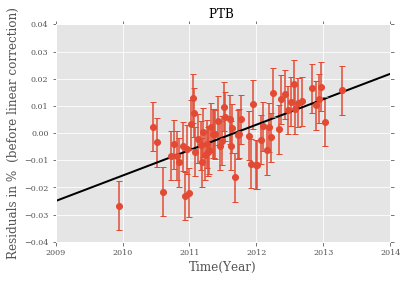

In [10]:
#plotting the above data 

#plotting the above data
import statistics
yp = np.poly1d(np.polyfit(year, rel_diff1*100, 1))
xp = [2009,2010,2011,2012,2013,2014]
# print(np.diff(year))
# print(statistics.median(np.diff(year))
# )



plt.ylim(-0.04,0.04) 
plt.plot( xp, yp(xp), 'k',linewidth=2)

# plt.plot( xp, yp(xp), '--')
plt.errorbar(year,rel_diff1*100,dy,fmt='o',alpha=1)

# plt.plot(year, rel_diff1*100,'o')
# plt.xlim(2010,2013)
plt.savefig('demo1.png')

# plt.errorbar(year,rel_diff1,dy,fmt='o')		
plt.title('PTB ',fontsize=12)
plt.xlabel('Time(Year)',fontsize=12)
plt.ylabel('Residuals in %  (before linear correction)',fontsize=12)
plt.savefig('rev1.png')

plt.show()


9.364680899539894e-05 0.8116135255987273


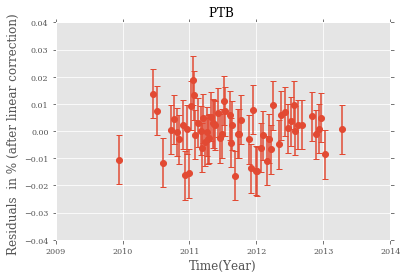

In [11]:
#after applying linear regression to above data
from matplotlib.pyplot import figure, show
from matplotlib.ticker import MaxNLocator
m,b = np.polyfit(year, data, 1)
print(m,b)

data1 = []
for i in range(len(data)):
    data1.append(data[i] - (m*year[i]+b))

avg = np.mean(data1)
data2 = data1 - avg


xp = [2009,2010,2011,2012,2013,2014]
yp = [-0.04]*6

plt.plot( xp, yp, 'k',linewidth=1)

plt.errorbar(year,data2*100,dy,fmt='o',alpha=1)
            
plt.ylim(-0.04,0.04) 
plt.style.use('ggplot')


plt.title('PTB ',fontsize=12)
plt.xlabel('Time(Year)',fontsize=12)
plt.ylabel('Residuals  in % (after linear correction) ',fontsize=12)
plt.savefig('PTB2.png')
plt.show()

In [12]:
#Applying LombScargle Periodogram

ls = LombScargle(year, data1, dy)
frequency, power = ls.autopower()

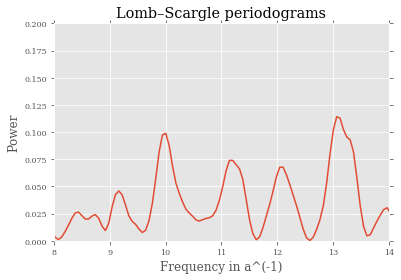

In [13]:
#plotting power vs frequency | xlim(8,14)

plt.xlim(8,14)
plt.ylim(0,0.2)
plt.plot(frequency, power)  
plt.style.use('ggplot')
plt.title('Lomb–Scargle periodograms')
plt.xlabel('Frequency in a^(-1)')
plt.ylabel('Power')
plt.show()

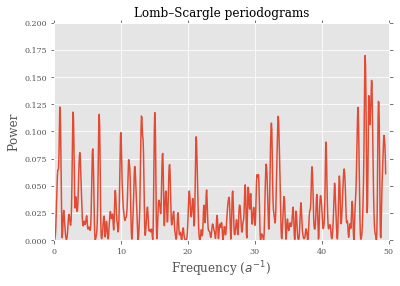

In [7]:
#plotting power vs frequency | xlim(0,50)

plt.xlim(0,50)
plt.ylim(0,0.2)
plt.plot(frequency, power)  
plt.style.use('ggplot')
plt.title('Lomb–Scargle periodograms',fontsize=12)
plt.xlabel('Frequency ($a^{-1}$)',fontsize=12)
plt.ylabel('Power',fontsize=12)
plt.show()


In [ ]:
#Defining FAP to find significance of peaks 

def false_alarm(method):
    return ls.false_alarm_probability(z, method = method, maximum_frequency = 5 )


#peak detection

from scipy.signal import argrelextrema

# for local maxima
a = argrelextrema(power, np.greater)

# for local minima
b = argrelextrema(power, np.less)


In [ ]:

import xlsxwriter 
  
workbook = xlsxwriter.Workbook('PTB_FAP.xlsx') 
  
worksheet = workbook.add_worksheet() 
  

worksheet.write('A1', 'Power') 
worksheet.write('B1', 'Frequency') 
worksheet.write('C1', 'FAP : baluev') 
worksheet.write('D1', 'FAP : davies') 
worksheet.write('E1', 'FAP : naive') 
worksheet.write('F1', 'FAP : bootstrap') 

row = 1
col = 0
count = 0
sig = []
for i in range(len(a[0])): 
    worksheet.write(row, col, power[a[0][i]]) 
    worksheet.write(row, col + 1, frequency[a[0][i]]) 

    worksheet.write(row, col + 2, ls.false_alarm_probability(power[a[0][i]], method='baluev'))
    worksheet.write(row, col + 3, ls.false_alarm_probability(power[a[0][i]], method='davies'))
    worksheet.write(row, col + 4, ls.false_alarm_probability(power[a[0][i]], method='naive'))

    q = ls.false_alarm_probability(power[a[0][i]], method='bootstrap')
    worksheet.write(row, col + 5, q)
    if  q<0.1:
        count = count + 1
        print(count)
        worksheet.write(row, col + 6, q)
        sig.append(a[0][i])


    row += 1

workbook.close() 
print(sig)